<a href="https://colab.research.google.com/github/i-kartikk/PRODIGY__ML__02/blob/main/TASK%202%7CCustomer_Segmentation%7CK_Means_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:


import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'customer-segmentation-tutorial-in-python:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F42674%2F74935%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240905%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240905T061703Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3b642594cad8956d31348493eaaadb234ca95d733a66cfb6a7221eca459b838ed9d0054c034134dbc9796349cf2cc7e2e54147868e699356a6ba02732c5351dcca9d0bfef065c5be7875c67078ae162cc94d7653ac68886ca51154d22161f06e8148aa23d599860f5d6bfa96f2d5d0d953ccd36ac748f54ced1af076b877e4888257f06a0b194301d725112774e3bda956820802f09386babf0c2889e4a630e7d8e5d181a74e0a61206d58a266094e7499ea543a41131e98291c87fa80d533c22247fd457ab249758e59b2b1a70b9612a443855b6459a75a2a6b64ed862d04807cb54ada54f84e6692323790bed09e887f402897ad12822e2e0dc60a27772326'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1583 bytes downloaded
Downloaded and uncompressed: customer-segmentation-tutorial-in-python
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans

In [3]:
customer =pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

In [4]:
customer.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
customer.shape

(200, 5)

In [6]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [7]:
customer.isna().sum()

,0
CustomerID,0
Gender,0
Age,0
Annual Income (k$),0
Spending Score (1-100),0


In [8]:
customer.duplicated().sum()

0

In [10]:
customer.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [9]:
x= customer.iloc[:,[3,4]].values

In [11]:
x

array([[ 15,  39],
       [ 15,  81],
       [ 16,   6],
       [ 16,  77],
       [ 17,  40],
       [ 17,  76],
       [ 18,   6],
       [ 18,  94],
       [ 19,   3],
       [ 19,  72],
       [ 19,  14],
       [ 19,  99],
       [ 20,  15],
       [ 20,  77],
       [ 20,  13],
       [ 20,  79],
       [ 21,  35],
       [ 21,  66],
       [ 23,  29],
       [ 23,  98],
       [ 24,  35],
       [ 24,  73],
       [ 25,   5],
       [ 25,  73],
       [ 28,  14],
       [ 28,  82],
       [ 28,  32],
       [ 28,  61],
       [ 29,  31],
       [ 29,  87],
       [ 30,   4],
       [ 30,  73],
       [ 33,   4],
       [ 33,  92],
       [ 33,  14],
       [ 33,  81],
       [ 34,  17],
       [ 34,  73],
       [ 37,  26],
       [ 37,  75],
       [ 38,  35],
       [ 38,  92],
       [ 39,  36],
       [ 39,  61],
       [ 39,  28],
       [ 39,  65],
       [ 40,  55],
       [ 40,  47],
       [ 40,  42],
       [ 40,  42],
       [ 42,  52],
       [ 42,  60],
       [ 43,

In [12]:
sse = []

for i in range(1,11):
  kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
  kmeans.fit(x)

  sse.append(kmeans.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

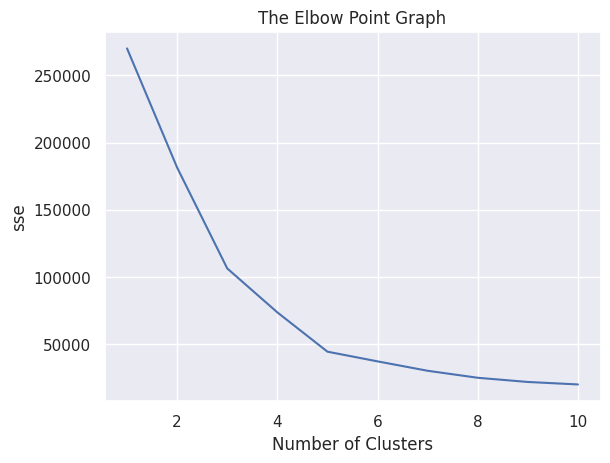

In [13]:
sns.set()
plt.plot(range(1,11), sse)
plt.title('The Elbow Point Graph')
plt.xlabel('Number of Clusters')
plt.ylabel('sse')
plt.show()

In [14]:
kmeans = KMeans(n_clusters=5, random_state=0)
y = kmeans.fit_predict(x)
print(y)

[3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3 4 3
 4 3 4 3 4 3 0 3 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 0 1 2 1 2 1 0 1 2 1 2 1 2 1 2 1 0 1 2 1 2 1
 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2
 1 2 1 2 1 2 1 2 1 2 1 2 1 2 1]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


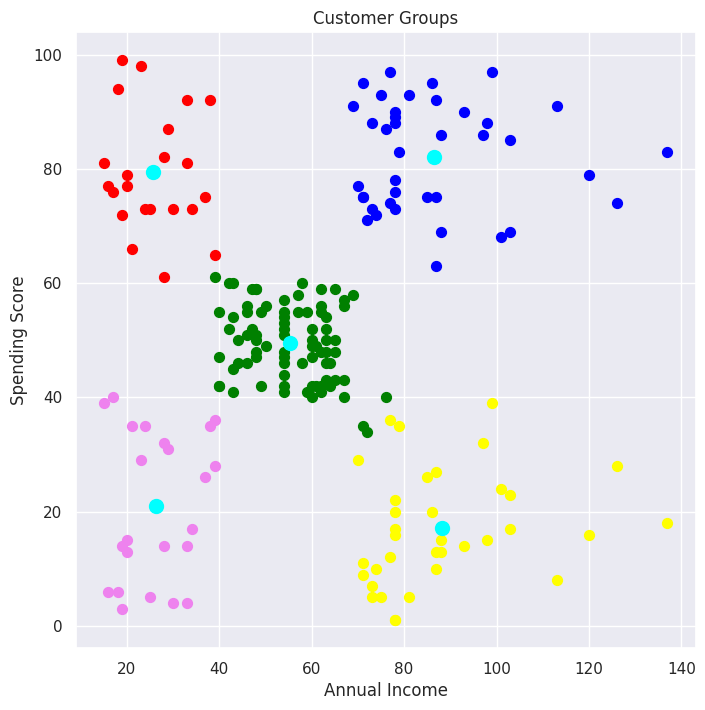

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(x[y==0,0], x[y==0,1], s=50, c='green', label='Cluster 1')
plt.scatter(x[y==1,0], x[y==1,1], s=50, c='blue', label='Cluster 2')
plt.scatter(x[y==2,0], x[y==2,1], s=50, c='yellow', label='Cluster 3')
plt.scatter(x[y==3,0], x[y==3,1], s=50, c='violet', label='Cluster 4')
plt.scatter(x[y==4,0], x[y==4,1], s=50, c='red', label='Cluster 5')

plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], s=100, c='cyan', label='Centroids')

plt.title('Customer Groups')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')
plt.show()